In [ ]:
# 加载必要的库
library(reticulate)
library(Seurat)
library(zellkonverter)  # 或者使用 SeuratDisk 进行转换

# 定义转换函数
convert_h5ad_to_rdata <- function(h5ad_file_path, rdata_file_path) {
  # 加载 anndata Python 包
  anndata <- reticulate::import("anndata", convert = FALSE)
  
  # 读取 h5ad 文件为 AnnData 对象
  adata <- anndata$read_h5ad(h5ad_file_path)
  
  # 将 AnnData 对象转换为 Seurat 对象（也可以直接转换为 Bioconductor 对象）
  seurat_object <- as.Seurat(adata)
  
  # 保存为 RData 文件
  save(seurat_object, file = rdata_file_path)
  
  message("Conversion completed and saved to: ", rdata_file_path)
}

# 使用示例
h5ad_file <- "example.h5ad"  # 请替换为你的 h5ad 文件路径
rdata_file <- "example.RData"  # 请替换为你希望保存的 RData 文件路径

convert_h5ad_to_rdata(h5ad_file, rdata_file)

## test MMD + Kernel

In [ ]:
# 计算核矩阵的函数
compute_kernel_matrix <- function(samples1, samples2, sigma = 1.0) {
  n <- dim(samples1)[1]
  m <- dim(samples2)[1]
  K <- matrix(0, nrow = n, ncol = m)
  
  for (i in 1:n) {
    for (j in 1:m) {
      # 提取第 i 个和第 j 个样本
      x_i <- samples1[i, , ]  # (m x k)
      y_j <- samples2[j, , ]  # (m x k)

      # 计算 SWD
      swd_value <- sliced_wasserstein_distance(x_i, y_j)
      
      # 计算核值
      K[i, j] <- GaussianEMDKernel(swd_value, sigma)
    }
  }
  return(K)
}

compute_kernel_matrix <- function(samples1, samples2, sigma = 1.0) {
  # 计算所有样本对的 SWD 距离矩阵
  swd_matrix <- outer(1:nrow(samples1), 1:nrow(samples2), Vectorize(function(i, j) {
    sliced_wasserstein_distance(samples1[i, ,], samples2[j, ,])
  }))

  # 使用矢量化的方式计算核矩阵
  K <- exp(-swd_matrix^2 / (2 * sigma^2))
  return(K)
}

# 高斯 EMD 核函数
GaussianEMDKernel <- function(swd_value, sigma = 1.0) {
  return(exp(-swd_value^2 / (2 * sigma^2)))
}

In [39]:
dim(samples1)

[1]  10 100  10

In [ ]:
# 计算 MMD 的函数
compute_mmd <- function(samples1, samples2, sigma = 1.0) {
  # 计算核矩阵
  K_XX <- compute_kernel_matrix(samples1, samples1, sigma)

  K_YY <- compute_kernel_matrix(samples2, samples2, sigma)
  K_XY <- compute_kernel_matrix(samples1, samples2, sigma)
  
  # 计算 MMD 的平方
  mmd <- mean(K_XX) + mean(K_YY) - 2 * mean(K_XY)
  return(mmd)
}

# 计算核矩阵的函数
compute_kernel_matrix <- function(samples1, samples2, sigma = 1.0) {
  n <- dim(samples1)[1]
  m <- dim(samples2)[1]
  K <- matrix(0, nrow = n, ncol = m)
  
  for (i in 1:n) {
    for (j in 1:m) {
      # 提取第 i 个和第 j 个样本
      x_i <- samples1[i, , ]  # (m x k)
      y_j <- samples2[j, , ]  # (m x k)

      # 计算 SWD
      swd_value <- sliced_wasserstein_distance(x_i, y_j)
      
      # 计算核值
      K[i, j] <- GaussianEMDKernel(swd_value, sigma)
    }
  }
  return(K)
}

# 计算 Sliced Wasserstein Distance (SWD)
sliced_wasserstein_distance <- function(first_samples, second_samples, num_projections = 512, p = 2) {
  # 计算样本的维度
  dim <- ncol(first_samples)  # dim = D, 每个样本的特征维度
  
  # 生成随机投影矩阵
  projections <- rand_projections(dim, num_projections)  # shape: (num_projections, D)
  
  # 计算第一个样本集的投影
  first_projections <- first_samples %*% t(projections)  # shape: (N1, num_projections)
  
  # 计算第二个样本集的投影
  second_projections <- second_samples %*% t(projections)  # shape: (N2, num_projections)

  # 对投影结果按行排序
  first_sorted <- t(apply(first_projections, 1, sort))  # shape: (N1, num_projections)
  second_sorted <- t(apply(second_projections, 1, sort))  # shape: (N2, num_projections)

  # 计算 Wasserstein 距离
  wasserstein_distance <- rowMeans(abs(first_sorted - second_sorted)^p)^(1/p)  # shape: (N1 or N2,)

  # 返回平均 SWD 值
  return(mean(wasserstein_distance))  # 返回标量
}

# 生成随机投影矩阵
rand_projections <- function(dim, num_projections = 1000) {
  # 生成形状为 (num_projections, dim) 的随机矩阵
  projections <- matrix(rnorm(num_projections * dim), nrow = num_projections)
  
  # 归一化每个投影向量，使其单位长度
  projections <- projections / sqrt(rowSums(projections^2))
  return(projections)
}

# 高斯 EMD 核函数
GaussianEMDKernel <- function(swd_value, sigma = 1.0) {
  return(exp(-swd_value^2 / (2 * sigma^2)))
}

# 使用示例
set.seed(42)

# 生成示例数据
N <- 10  # 样本数量
m <- 1000   # 样本的第2维度
k <- 5   # 样本的第3维度

# samples1 和 samples2 是三维数组 (N x m x k)
samples1 <- array(rnorm(N * m * k, mean = 0, sd = 1), dim = c(N, m, k))
samples2 <- array(rnorm(N * m * k, mean = 1, sd = 1), dim = c(N, m, k))

# 初始化高斯 EMD 核的 sigma 值
sigma_value <- 1.0

# 计算 MMD
mmd_value <- compute_mmd(samples1, samples2, sigma = sigma_value)
cat(sprintf("最终的 MMD 值: %.6f\n", mmd_value))

---

In [2]:
library(foreach)
library(doParallel)

# 计算 MMD 的函数
compute_mmd <- function(samples1, samples2, sigma = 1.0) {
  K_XX <- compute_kernel_matrix(samples1, samples1, sigma)
  K_YY <- compute_kernel_matrix(samples2, samples2, sigma)
  K_XY <- compute_kernel_matrix(samples1, samples2, sigma)
  mmd <- mean(K_XX) + mean(K_YY) - 2 * mean(K_XY)
  return(mmd)
}

compute_kernel_matrix <- function(samples1, samples2, sigma = 1.0) {
  n <- dim(samples1)[1]
  m <- dim(samples2)[1]
  
  index_list <- expand.grid(i = 1:n, j = 1:m)
  
  # 并行计算核矩阵元素
  K_values <- foreach(idx = 1:nrow(index_list), .combine = 'c', .export = c("samples1", "samples2", "sliced_wasserstein_distance", "GaussianEMDKernel", "rand_projections")) %dopar% {
    i <- index_list[idx, "i"]
    j <- index_list[idx, "j"]
    x_i <- samples1[i, , ]
    y_j <- samples2[j, , ]
    swd_value <- sliced_wasserstein_distance(x_i, y_j)
    GaussianEMDKernel(swd_value, sigma)
  }
  
  # 组装核矩阵
  K <- matrix(K_values, nrow = n, ncol = m, byrow = TRUE)
  return(K)
}

sliced_wasserstein_distance <- function(first_samples, second_samples, num_projections = 512, p = 2) {
  dim <- ncol(first_samples)
  
  # 生成随机投影矩阵
  projections <- rand_projections(dim, num_projections)  # (num_projections, dim)
  
  # 计算投影
  first_projections <- first_samples %*% t(projections)  # (m, num_projections)
  second_projections <- second_samples %*% t(projections)  # (m, num_projections)
  
  # 对每个投影维度排序
  first_sorted <- apply(first_projections, 2, sort)
  second_sorted <- apply(second_projections, 2, sort)
  
  # 计算 Wasserstein 距离
  wasserstein_distance <- (colMeans(abs(first_sorted - second_sorted)^p))^(1/p)
  
  # 返回平均 SWD 值
  return(mean(wasserstein_distance))
}


# 生成随机投影矩阵
rand_projections <- function(dim, num_projections = 512) {
  # 生成形状为 (num_projections, dim) 的随机矩阵
  projections <- matrix(rnorm(num_projections * dim), nrow = num_projections)
  
  # 归一化每个投影向量，使其单位长度
  projections <- projections / sqrt(rowSums(projections^2))
  return(projections)
}

# 高斯 EMD 核函数
GaussianEMDKernel <- function(swd_value, sigma = 1.0) {
  return(exp(-swd_value^2 / (2 * sigma^2)))
}

# 使用示例
set.seed(42)

# 生成示例数据
N <- 5  # 样本数量
m <- 10000   # 样本的第2维度
k <- 5   # 样本的第3维度

# samples1 和 samples2 是三维数组 (N x m x k)
samples1 <- array(rnorm(N * m * k, mean = 0, sd = 1), dim = c(N, m, k))
samples2 <- array(rnorm(N * m * k, mean = 1, sd = 1), dim = c(N, m, k))

# 初始化高斯 EMD 核的 sigma 值
sigma_value <- 1.0

# 计算 MMD
mmd_value <- compute_mmd(samples1, samples2, sigma = sigma_value)
cat(sprintf("最终的 MMD 值: %.6f\n", mmd_value))

Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
"already exporting variable(s): samples1, samples2"


ERROR: Error in summary.connection(connection): invalid connection


In [ ]:
compute_kernel_matrix <- function(samples1, samples2, sigma = 1.0) {
  n <- dim(samples1)[1]
  m <- dim(samples2)[1]
  
  # 并行计算核矩阵元素
  K_values <- foreach(i = 1:n, .combine = 'rbind', .export = c("samples1", "samples2", "sliced_wasserstein_distance", "GaussianEMDKernel", "rand_projections")) %dopar% {
    K_row <- numeric(m)
    for (j in 1:m) {
      x_i <- samples1[i, , ]
      y_j <- samples2[j, , ]
      swd_value <- sliced_wasserstein_distance(x_i, y_j)
      K_row[j] <- GaussianEMDKernel(swd_value, sigma)
    }
    K_row
  }
  
  # 组装核矩阵
  K <- t(K_values)
  return(K)
}

In [3]:
library(foreach)
library(doParallel)

# 计算 MMD 的函数
compute_mmd <- function(samples1, samples2, sigma = 1.0) {
  K_XX <- compute_kernel_matrix(samples1, samples1, sigma)
  K_YY <- compute_kernel_matrix(samples2, samples2, sigma)
  K_XY <- compute_kernel_matrix(samples1, samples2, sigma)
  mmd <- mean(K_XX) + mean(K_YY) - 2 * mean(K_XY)
  return(mmd)
}

compute_kernel_matrix <- function(samples1, samples2, sigma = 1.0) {
  n <- dim(samples1)[1]
  m <- dim(samples2)[1]
  
  # 并行计算核矩阵元素
  K_values <- foreach(i = 1:n, .combine = 'rbind', .export = c("sliced_wasserstein_distance", "GaussianEMDKernel", "rand_projections")) %dopar% {
    K_row <- numeric(m)
    for (j in 1:m) {
      x_i <- samples1[i, , ]
      y_j <- samples2[j, , ]
      swd_value <- sliced_wasserstein_distance(x_i, y_j)
      K_row[j] <- GaussianEMDKernel(swd_value, sigma)
    }
    K_row
  }
  
  # 组装核矩阵
  K <- t(K_values)
  return(K)
}

sliced_wasserstein_distance <- function(first_samples, second_samples, num_projections = 512, p = 2) {
  dim <- ncol(first_samples)
  
  # 生成随机投影矩阵
  projections <- rand_projections(dim, num_projections)  # (num_projections, dim)
  
  # 计算投影
  first_projections <- first_samples %*% t(projections)  # (m, num_projections)
  second_projections <- second_samples %*% t(projections)  # (m, num_projections)
  
  # 对每个投影维度排序
  first_sorted <- apply(first_projections, 2, sort)
  second_sorted <- apply(second_projections, 2, sort)
  
  # 计算 Wasserstein 距离
  wasserstein_distance <- (colMeans(abs(first_sorted - second_sorted)^p))^(1/p)
  
  # 返回平均 SWD 值
  return(mean(wasserstein_distance))
}

# 生成随机投影矩阵
rand_projections <- function(dim, num_projections = 512 , seed = 42) {
  
  set.seed(seed)
  
  # 生成形状为 (num_projections, dim) 的随机矩阵
  projections <- matrix(rnorm(num_projections * dim), nrow = num_projections)
  
  # 归一化每个投影向量，使其单位长度
  projections <- projections / sqrt(rowSums(projections^2))
  return(projections)
}

# 高斯 EMD 核函数
GaussianEMDKernel <- function(swd_value, sigma = 1.0) {
  return(exp(-swd_value^2 / (2 * sigma^2)))
}

# 使用示例
set.seed(42)

# 生成示例数据
N <- 5  # 样本数量
m <- 10000   # 样本的第2维度
k <- 5   # 样本的第3维度

# samples1 和 samples2 是三维数组 (N x m x k)
samples1 <- array(rnorm(N * m * k, mean = 0, sd = 1), dim = c(N, m, k))
samples2 <- array(rnorm(N * m * k, mean = 1, sd = 1), dim = c(N, m, k))

# 初始化高斯 EMD 核的 sigma 值
sigma_value <- 1.0

# 注册并行计算
cl <- makeCluster(detectCores() - 1)
registerDoParallel(cl)

# 计算 MMD
mmd_value <- compute_mmd(samples1, samples2, sigma = sigma_value)
cat(sprintf("最终的 MMD 值: %.6f\n", mmd_value))

# 停止并行计算
stopCluster(cl)

最终的 MMD 值: 0.628192


In [1]:
# 生成示例数据

m <- 10000   # 样本的第2维度
k <- 5   # 样本的第3维度

# samples1 和 samples2 是三维数组 (N x m x k)
samples1 <- array(rnorm(m * k, mean = 0, sd = 1), dim = c(m, k))
samples2 <- array(rnorm(m * k, mean = 1, sd = 1), dim = c(m, k))

In [ ]:
density()

In [ ]:
library(np)

# npudens

kde <- npudens(tdat = samples1 , bw = 0.1)

Nonparametric Kernel Methods for Mixed Datatypes (version 0.60-17)
[vignette("np_faq",package="np") provides answers to frequently asked questions]
[vignette("np",package="np") an overview]
[vignette("entropy_np",package="np") an overview of entropy-based methods]



In [11]:
library(ks)

# ks

kde <- kde(x = samples1, h = 0.1 , binned = TRUE)

In [1]:
from sklearn.neighbors import KernelDensity
import numpy

m = 10000
k = 5
samples1 = numpy.random.normal(0, 1, (m, k))
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(samples1)

In [2]:
sampled = kde.sample(10000 ,random_state=42) 

In [12]:
library(transport)

dist <- wasserstein1d(c(0, 1, 0, 0) / sum(c(0, 1, 0, 0)), c(1, 0, 0, 0) / sum(c(1, 0, 0, 0)))
print(dist)

[1] 0


In [10]:
  x <- rnorm(200)
  y <- rnorm(150,2)
  wasserstein1d(x,y)

[1] 1.755517

In [5]:
import ot
import numpy as np

# 定义两个一维分布
a = np.array([0, 0, 0, 1], dtype=np.float64)  # 这里最后一个元素为1
b = np.array([0, 0, 1, 0], dtype=np.float64)  # 这里第三个元素为1

# 定义均匀的权重分布
a = a / np.sum(a)  # 归一化，使其为概率分布
b = b / np.sum(b)  # 归一化，使其为概率分布

# 定义距离矩阵（这里是1维的点到点距离）
M = ot.dist(np.arange(len(a)).reshape(-1, 1), np.arange(len(b)).reshape(-1, 1))

# 计算Wasserstein距离
dist = ot.emd2(a, b, M)
print("Wasserstein距离:", dist)

Wasserstein距离: 1.0


In [1]:
# 加载 transport 包
library(transport)

# 定义两个一维分布
a <- c(0, 0, 0, 1)
b <- c(0, 0, 1, 0)

# 归一化分布，使它们成为概率分布
a <- a / sum(a)
b <- b / sum(b)

# 定义一维 Wasserstein 距离的距离矩阵
n <- length(a)
cost_matrix <- abs(outer(1:n, 1:n, "-"))

# 计算 Wasserstein 距离
dist <- wasserstein(a, b, costm = cost_matrix)
print(paste("Wasserstein距离:", dist))


[1] "Wasserstein距离: 1"


In [ ]:
# 加载 reticulate 包
library(reticulate)

# 使用 Python 环境中的 sklearn 和 numpy


# 定义函数
fit_kde_and_sample <- function(samples, num_samples, sample_times, bandwidth = NULL, random_seed = NULL) {
  sklearn <- import("sklearn.neighbors")
  np <- import("numpy")
  
  # 将 R 的数据转换为 Python 格式
  samples_py <- r_to_py(as.matrix(samples))
  
  # 创建并拟合 KDE 模型
  kde <- sklearn$KernelDensity(kernel = "gaussian", bandwidth = bandwidth)
  kde$fit(samples_py)
  
  # 初始化样本集合
  samples_set <- vector("list", sample_times)
  
  # 采样
  for (i in seq_len(sample_times)) {
    # 使用 kde$sample() 生成样本
    sampled <- kde$sample(n_samples = as.integer(num_samples), random_state = as.integer(random_seed + i))
    
    # 将样本裁剪在 [0, 1] 范围内
    sampled <- np$clip(sampled, 0, 1)
    
    # 将采样结果转换回 R 格式，并保存
    samples_set[[i]] <- py_to_r(sampled)
  }
  
  return(samples_set)
}

# 示例用法
# 假设样本数据如下
# 生成示例数据

m <- 10000   # 样本的第2维度
k <- 4   # 样本的第3维度

# samples1 和 samples2 是三维数组 (N x m x k)
samples1 <- array(rnorm(m * k, mean = 0, sd = 1), dim = c(m, k))
samples2 <- array(rnorm(m * k, mean = 1, sd = 1), dim = c(m, k))


num_samples <- 10000                        # 每次采样的数量
sample_times <- 5                        # 采样次数
bandwidth <- 0.2                         # KDE 带宽
random_seed <- 42                        # 随机种子

# 调用函数
samples_set <- fit_kde_and_sample(samples1, num_samples, sample_times, bandwidth, random_seed)

# 查看采样结果
print(samples_set)


In [ ]:
library(ks)

# ks

kde <- kde(x = samples1, h = 0.1 , binned = TRUE)

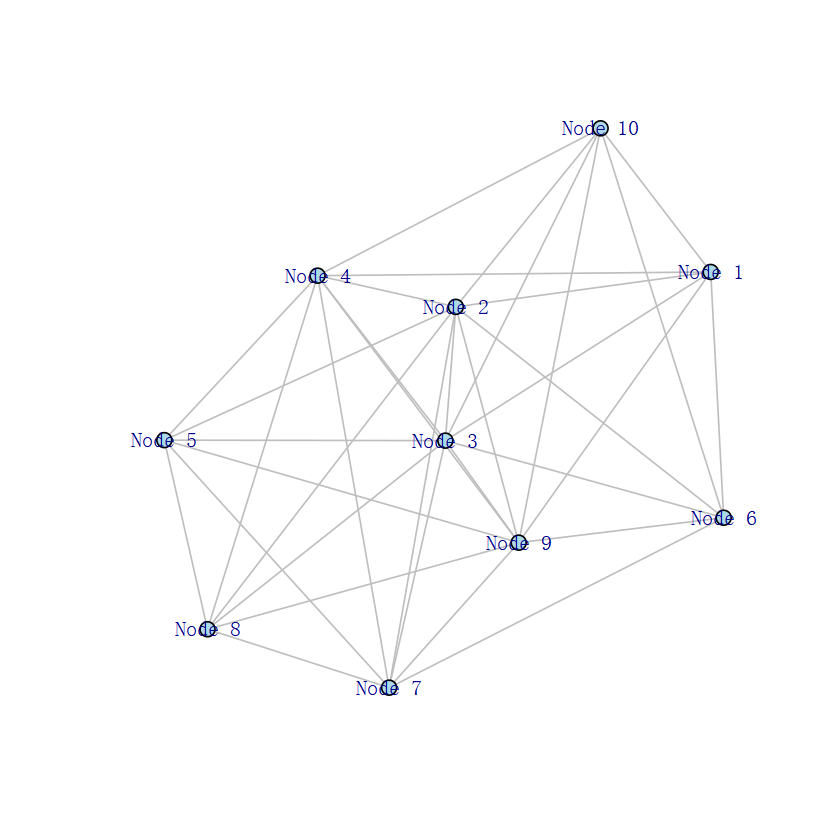

In [6]:
library(igraph)
library(RANN)
# 定义 build_graph 函数
build_graph <- function(label_data, coordinate_data, num_neighbors = 6) {
  nbrs <- nn2(coordinate_data, k = num_neighbors + 1) 
  sources <- rep(seq_len(nrow(nbrs$nn.idx)), each = num_neighbors)
  targets <- as.vector(t(nbrs$nn.idx[, -1]))
  edge_list <- c(rbind(sources, targets))

  graph <- make_graph(edge_list, directed = FALSE) %>% simplify()

  V(graph)$label <- label_data
  V(graph)$pos <- split(coordinate_data, seq(nrow(coordinate_data)))

  return(graph)
}

# 创建示例数据
set.seed(123)  # 设置随机种子以便重复
num_nodes <- 10
coordinate_data <- matrix(runif(num_nodes * 2), ncol = 2)  # 生成 10 个随机坐标
label_data <- paste("Node", 1:num_nodes)  # 创建节点标签

# 调用 build_graph 函数
graph <- build_graph(label_data, coordinate_data)

# 可视化图形
plot(graph, vertex.label = V(graph)$label, vertex.size = 5,
     vertex.color = "lightblue", edge.color = "gray", 
     layout = layout_with_fr)

In [10]:
# 创建一个维度为 (4, 3, 2) 的数组
my_array <- array(data = 1:24, dim = c(4, 3, 2))

# 查看数组的维度
dim(my_array)

[1] 4 3 2

In [22]:
# 写出到csv
write.csv(my_array, "my_array.csv")

In [21]:
print(my_array)

, , 1

     [,1] [,2] [,3]
[1,]    1    5    9
[2,]    2    6   10
[3,]    3    7   11
[4,]    4    8   12

, , 2

     [,1] [,2] [,3]
[1,]   13   17   21
[2,]   14   18   22
[3,]   15   19   23
[4,]   16   20   24



In [20]:
print(my_array[,,1])

     [,1] [,2] [,3]
[1,]    1    5    9
[2,]    2    6   10
[3,]    3    7   11
[4,]    4    8   12


In [17]:
print(my_array[1,,])

     [,1] [,2]
[1,]    1   13
[2,]    5   17
[3,]    9   21


In [14]:
# 创建一个包含多个数据框的列表
samples <- list(
  data.frame(A = 1:3, B = 4:6),
  data.frame(A = 7:9, B = 10:12),
  data.frame(A = 13:15, B = 16:18)
)

# 使用 do.call 和 rbind 将列表中的数据框按行合并
combined_samples <- do.call(rbind, samples)

# 查看合并后的数据框
print(combined_samples)

   A  B
1  1  4
2  2  5
3  3  6
4  7 10
5  8 11
6  9 12
7 13 16
8 14 17
9 15 18


In [15]:
data.frame(A = 1:3, B = 4:6)

A,B
<int>,<int>
1,4
2,5
3,6


In [16]:
data.frame(A = 7:9, B = 10:12)

A,B
<int>,<int>
7,10
8,11
9,12


In [ ]:
sliced_wasserstein_distance <- function(first_samples, second_samples, num_projections = 512, p = 2) {
  dim <- ncol(first_samples)
  
  # rand projection matrix
  projections <- rand_projections(dim, num_projections)  # (num_projections, dim)
  
  # 计算投影
  first_projections <- first_samples %*% t(projections)  # (m, num_projections)
  second_projections <- second_samples %*% t(projections)  # (m, num_projections)
  
  # 对每个投影维度排序
  first_sorted <- apply(first_projections, 2, sort)
  second_sorted <- apply(second_projections, 2, sort)
  
  # 计算 Wasserstein 距离
  wasserstein_distance <- (colMeans(abs(first_sorted - second_sorted)^p))^(1/p)
  
  # 返回平均 SWD 值
  return(mean(wasserstein_distance))
}

# 生成随机投影矩阵
rand_projections <- function(dim, num_projections = 512 , seed = 42) {
  set.seed(seed)
  # 生成形状为 (num_projections, dim) 的随机矩阵
  projections <- matrix(rnorm(num_projections * dim), nrow = num_projections)
  
  # 归一化每个投影向量，使其单位长度
  projections <- projections / sqrt(rowSums(projections^2))
  return(projections)
}

first_samples <- array(rnorm(1000 * 5), dim = c(1000, 5))
second_samples <- array(rnorm(1000 * 5), dim = c(1000, 5))